# Лабораторная работа №2: Векторизация текста 

## 1. Импорт необходимых библиотек


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
import os

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Загрузка и подготовка данных


In [2]:
df = pd.read_csv('train.csv', header=None, names=['label', 'title', 'text'])
print(f"Размер датасета: {df.shape}")
print(df.head())

# Функция предобработки текста
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df['tokens'] = df['text'].apply(preprocess_text)
print("Пример токенизированного текста:")
print(df['tokens'].iloc[0][:20])


Размер датасета: (120000, 3)
   label                                              title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3      3  Iraq Halts Oil Exports from Main Southern Pipe...   
4      3  Oil prices soar to all-time record, posing new...   

                                                text  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  
Пример токенизированного текста:
['reuters', 'wall', 'street', 'seeing', 'green']


## 3. Обучение моделей Word2Vec


In [3]:
def train_word2vec_model(tokens_list, vector_size=100, window=5, min_count=5, workers=4):
    model = Word2Vec(
        sentences=tokens_list,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=0,  # 0 для CBOW, 1 для Skip-gram
        epochs=10
    )
    return model

w2v_model = train_word2vec_model(df['tokens'].tolist())
print(f"Размер словаря: {len(w2v_model.wv)}")


Размер словаря: 22764


## 4. Эксперименты с гиперпараметрами Word2Vec


In [4]:
def test_word2vec_hyperparameters(tokens_list, test_word='technology'):
    results = []
    
    # Различные комбинации гиперпараметров
    param_combinations = [
        {'vector_size': 50, 'window': 3, 'sg': 0},  # CBOW, маленькое окно
        {'vector_size': 50, 'window': 10, 'sg': 0}, # CBOW, большое окно
        {'vector_size': 100, 'window': 5, 'sg': 0}, # CBOW, средние параметры
        {'vector_size': 100, 'window': 5, 'sg': 1}, # Skip-gram, средние параметры
        {'vector_size': 200, 'window': 8, 'sg': 1}, # Skip-gram, большие векторы
    ]
    
    for params in param_combinations:
        model = Word2Vec(
            sentences=tokens_list,
            vector_size=params['vector_size'],
            window=params['window'],
            min_count=5,
            workers=4,
            sg=params['sg'],
            epochs=10
        )
        
        # Тестовые слова для сравнения
        similar_words = ['computer', 'internet', 'software']
        related_words = ['business', 'science', 'education']
        different_words = ['soccer', 'restaurant', 'travel']
        
        # Вычисляем средние косинусные расстояния
        similarities = []
        
        # Для похожих слов
        sim_scores = []
        for word in similar_words:
            if word in model.wv and test_word in model.wv:
                sim = cosine_similarity(
                    [model.wv[test_word]],
                    [model.wv[word]]
                )[0][0]
                sim_scores.append(sim)
        if sim_scores:
            similarities.append(('similar', np.mean(sim_scores)))
        
        # Для слов из той же области
        related_scores = []
        for word in related_words:
            if word in model.wv and test_word in model.wv:
                sim = cosine_similarity(
                    [model.wv[test_word]],
                    [model.wv[word]]
                )[0][0]
                related_scores.append(sim)
        if related_scores:
            similarities.append(('related', np.mean(related_scores)))
        
        # Для совершенно разных слов
        diff_scores = []
        for word in different_words:
            if word in model.wv and test_word in model.wv:
                sim = cosine_similarity(
                    [model.wv[test_word]],
                    [model.wv[word]]
                )[0][0]
                diff_scores.append(sim)
        if diff_scores:
            similarities.append(('different', np.mean(diff_scores)))
        
        results.append({
            'params': params,
            'similarities': similarities,
            'vocab_size': len(model.wv)
        })
    
    return results

w2v_results = test_word2vec_hyperparameters(df['tokens'].tolist())

for i, result in enumerate(w2v_results):
    print(f"\nМодель {i+1}:")
    print(f"Параметры: {result['params']}")
    print(f"Размер словаря: {result['vocab_size']}")
    for sim_type, score in result['similarities']:
        print(f"  Среднее косинусное расстояние для {sim_type} слов: {score:.4f}")



Модель 1:
Параметры: {'vector_size': 50, 'window': 3, 'sg': 0}
Размер словаря: 22764
  Среднее косинусное расстояние для similar слов: 0.4651
  Среднее косинусное расстояние для related слов: 0.3519
  Среднее косинусное расстояние для different слов: -0.0477

Модель 2:
Параметры: {'vector_size': 50, 'window': 10, 'sg': 0}
Размер словаря: 22764
  Среднее косинусное расстояние для similar слов: 0.4776
  Среднее косинусное расстояние для related слов: 0.3126
  Среднее косинусное расстояние для different слов: -0.1310

Модель 3:
Параметры: {'vector_size': 100, 'window': 5, 'sg': 0}
Размер словаря: 22764
  Среднее косинусное расстояние для similar слов: 0.3616
  Среднее косинусное расстояние для related слов: 0.2149
  Среднее косинусное расстояние для different слов: -0.0797

Модель 4:
Параметры: {'vector_size': 100, 'window': 5, 'sg': 1}
Размер словаря: 22764
  Среднее косинусное расстояние для similar слов: 0.5273
  Среднее косинусное расстояние для related слов: 0.3616
  Среднее косинус

## 5. Демонстрация работы лучшей модели


In [5]:
best_params = {'vector_size': 100, 'window': 5, 'sg': 1}
best_w2v_model = Word2Vec(
    sentences=df['tokens'].tolist(),
    vector_size=best_params['vector_size'],
    window=best_params['window'],
    min_count=5,
    workers=4,
    sg=best_params['sg'],
    epochs=10
)

test_words = ['apple', 'microsoft', 'economy', 'game']

for test_word in test_words:
    if test_word in best_w2v_model.wv:
        print(f"\nТестируем слово: '{test_word}'")
        
        similar_words = best_w2v_model.wv.most_similar(test_word, topn=5)
        print(f"  Наиболее похожие слова: {similar_words}")
        
        categories = {
            'similar': ['company', 'technology', 'business'],
            'related': ['fruit', 'computer', 'phone'],
            'different': ['soccer', 'movie', 'restaurant']
        }
        
        for category, words in categories.items():
            similarities = []
            for word in words:
                if word in best_w2v_model.wv:
                    sim = cosine_similarity(
                        [best_w2v_model.wv[test_word]],
                        [best_w2v_model.wv[word]]
                    )[0][0]
                    similarities.append(sim)
            if similarities:
                print(f"  Среднее косинусное расстояние для {category} слов: {np.mean(similarities):.4f}")




Тестируем слово: 'apple'
  Наиболее похожие слова: [('ipod', 0.8441943526268005), ('itunes', 0.8044136762619019), ('aapl', 0.7865098714828491), ('ipods', 0.7452389001846313), ('imac', 0.7350311279296875)]
  Среднее косинусное расстояние для similar слов: 0.3218
  Среднее косинусное расстояние для related слов: 0.3745
  Среднее косинусное расстояние для different слов: 0.2368

Тестируем слово: 'microsoft'
  Наиболее похожие слова: [('msft', 0.834881603717804), ('microsofts', 0.7214778661727905), ('windows', 0.7125650644302368), ('software', 0.6849817037582397), ('xp', 0.6830079555511475)]
  Среднее косинусное расстояние для similar слов: 0.4207
  Среднее косинусное расстояние для related слов: 0.3069
  Среднее косинусное расстояние для different слов: 0.1467

Тестируем слово: 'economy'
  Наиболее похожие слова: [('economic', 0.7315192818641663), ('sustainability', 0.7119507193565369), ('eurozone', 0.7027880549430847), ('breakneck', 0.6945838332176208), ('slowdown', 0.6943329572677612)]

## 6. Векторизация документа


In [6]:
def vectorize_document(text, word_vectors, vector_size=100):
    """
    Векторизация документа по алгоритму:
    1. Сегментация на предложения и токены
    2. Векторизация каждого токена
    3. Усреднение по предложениям
    4. Усреднение по документу
    """
    # Сегментация на предложения
    sentences = sent_tokenize(text)
    
    # Векторы для каждого предложения
    sentence_vectors = []
    
    for sentence in sentences:
        # Токенизация предложения
        tokens = word_tokenize(sentence.lower())
        tokens = [word for word in tokens if word.isalpha()]
        
        # Векторы для каждого токена
        token_vectors = []
        for token in tokens:
            if token in word_vectors:
                token_vectors.append(word_vectors[token])
        
        # Усреднение по токенам в предложении
        if token_vectors:
            sentence_vector = np.mean(token_vectors, axis=0)
            sentence_vectors.append(sentence_vector)
    
    # Усреднение по предложениям в документе
    if sentence_vectors:
        document_vector = np.mean(sentence_vectors, axis=0)
    else:
        document_vector = np.zeros(vector_size)
    
    return document_vector


## 7. Создание тестовой выборки и векторизация


In [7]:
test_documents = df.head(100).copy()

document_vectors = []
for idx, row in test_documents.iterrows():
    doc_vector = vectorize_document(row['text'], best_w2v_model.wv)
    document_vectors.append(doc_vector)

document_vectors_array = np.array(document_vectors)
print(f"Размер векторов документов: {document_vectors_array.shape}")


Размер векторов документов: (100, 100)


## 8. Сохранение результатов в TSV формате


In [8]:
def save_vectors_to_tsv(vectors, ids, filename='document_vectors.tsv'):
    """
    Сохраняет векторные представления в формате TSV
    
    Формат:
    <doc_id_1>  <embedding_1_component_1>  <embedding_1_component_2>  ...
    """
    with open(filename, 'w') as f:
        for doc_id, vector in zip(ids, vectors):
            # Форматируем вектор
            vector_str = '\t'.join([f"{x:.6f}" for x in vector])
            # Записываем строку
            f.write(f"{doc_id}\t{vector_str}\n")
    print(f"Векторы сохранены в {filename}")

document_ids = [f"{i:03d}" for i in range(len(test_documents))]

save_vectors_to_tsv(document_vectors_array, document_ids)


Векторы сохранены в document_vectors.tsv


## 9. Визуализация результатов


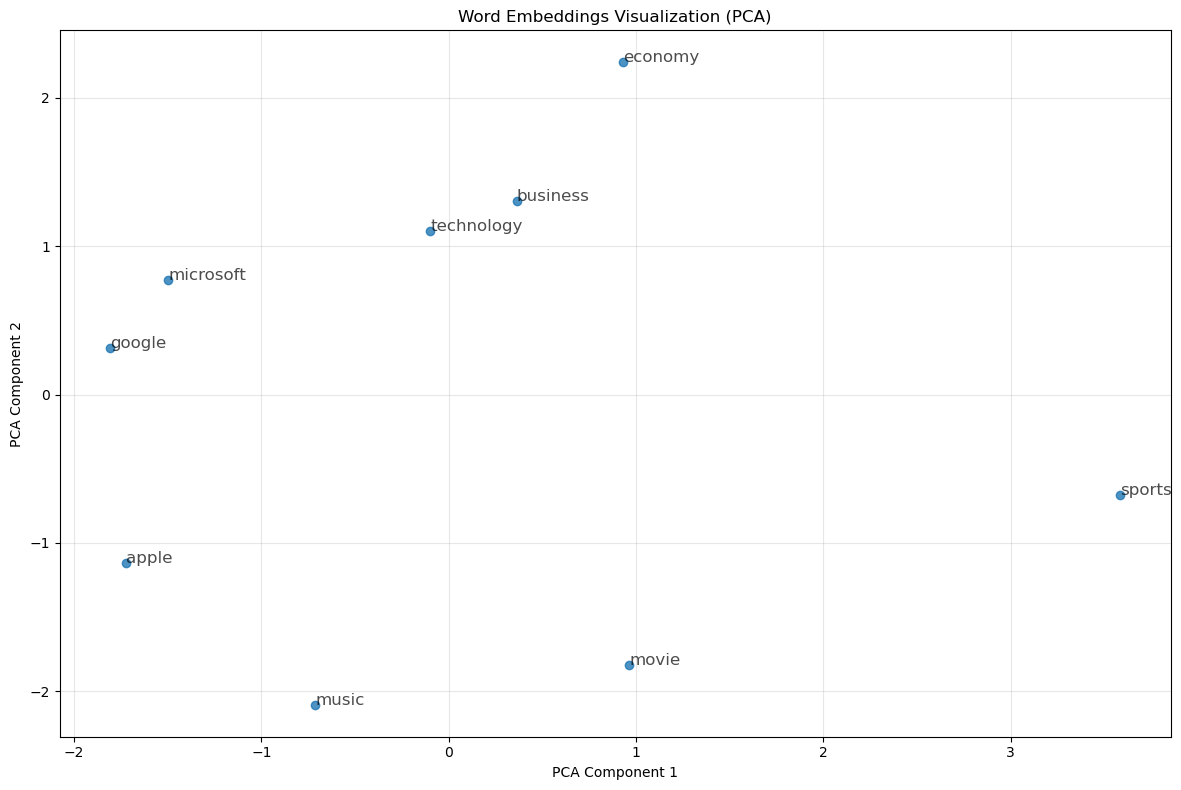

In [9]:
# Визуализация нескольких векторных представлений в 2D (с помощью PCA)
from sklearn.decomposition import PCA

def visualize_word_embeddings(model, words, filename='word_embeddings.png'):
    # Получаем векторы для слов
    vectors = []
    valid_words = []
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
            valid_words.append(word)
    
    if len(vectors) < 2:
        print("Недостаточно слов для визуализации")
        return
    
    # Применяем PCA для уменьшения размерности до 2D
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.8)
    
    for i, word in enumerate(valid_words):
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), 
                    fontsize=12, alpha=0.7)
    
    plt.title('Word Embeddings Visualization (PCA)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.show()

sample_words = ['apple', 'microsoft', 'google', 'technology', 
                'business', 'economy', 'sports', 'music', 'movie']
visualize_word_embeddings(best_w2v_model, sample_words)
